4×2 Matrix{ComplexF64}:
 -0.141603+0.230627im  0.0011637-0.121035im
  0.138599-0.205868im   0.436646-0.00795172im
  0.138599+0.205868im   0.436646+0.00795172im
 -0.141603-0.230627im  0.0011637+0.121035im

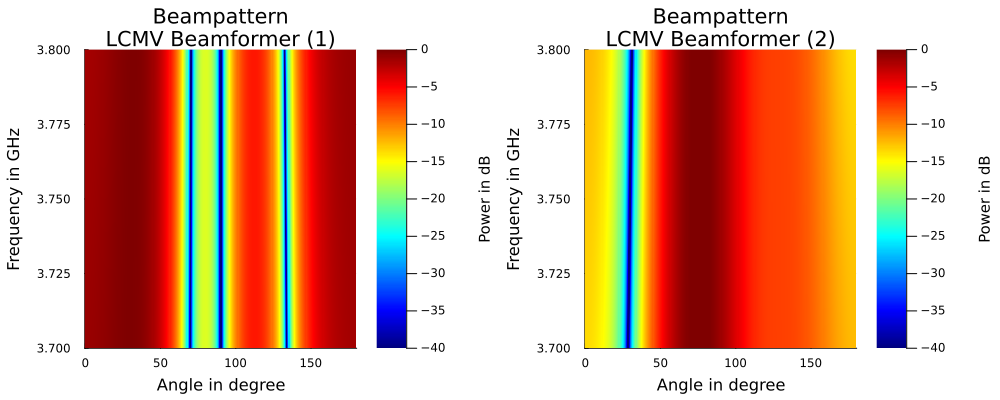

In [4]:
using ArraySignalProcessing
pa = IsotropicArray(-6e-2, -2e-2, 2e-2, 6e-2)

# Use the array below to better see the behaviour
#pa = IsotropicArray(Vector(LinRange(-20e-2, 20e-2, 16)))

# Diagonal loading is applied by adding whitenoise to the correlation matrix
Snn = diffnoise(pa, 1e3, 3.75e9) + whitenoise(pa, 1e-2)

# Constraints C set for three directions
C = steer(pa, deg2rad.([30 70 110]), 3.75e9)

# Two sets of gains for two sets of weights
G = [1 0; 0 1; 0.5 0.5]

weights = lcmv_weights(Snn, C, G)
display(weights)

faxis = LinRange(3.7e9, 3.8e9, 1024)
ϕaxis = LinRange(0, 180, 256)
A = steer.(Ref(pa), Ref(deg2rad.(ϕaxis)), faxis)
W1 = reduce(vcat, Ref(weights[:, 1]') .* A)
WdB1 = 20*log10.(abs.(W1))
W2 = reduce(vcat, Ref(weights[:, 2]') .* A)
WdB2 = 20*log10.(abs.(W2))

using Plots
import Measures
p1 = heatmap(ϕaxis, faxis/1e9, WdB1, cmap = :jet, clim=(-40, 0))
plot!(title="Beampattern\nLCMV Beamformer (1)", cbar_title="\nPower in dB", margin=5*Measures.mm)
xlabel!("Angle in degree")
ylabel!("Frequency in GHz")
p2 = heatmap(ϕaxis, faxis/1e9, WdB2, cmap = :jet, clim=(-40, 0))
plot!(title="Beampattern\nLCMV Beamformer (2)", cbar_title="\nPower in dB", margin=5*Measures.mm)
xlabel!("Angle in degree")
ylabel!("Frequency in GHz")

display(plot(p1, p2, layout=(1, 2), size=(1000, 400)))

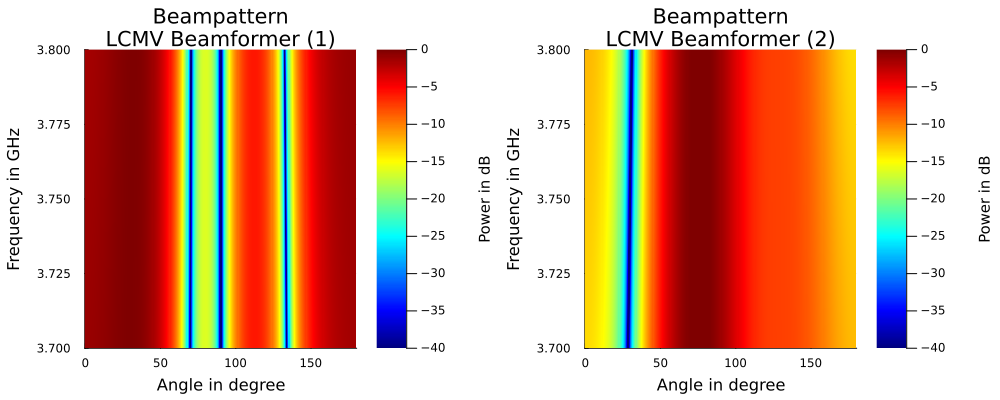

In [5]:
# Generalized Sidelobe Canceller (GSC) from LCMV starting point
WQ, B, WA = lcmv_gsc(Snn, C, G)
weights = WQ - B * WA

W1 = reduce(vcat, Ref(weights[:, 1]') .* A)
WdB1 = 20*log10.(abs.(W1))
W2 = reduce(vcat, Ref(weights[:, 2]') .* A)
WdB2 = 20*log10.(abs.(W2))

using Plots
import Measures
p1 = heatmap(ϕaxis, faxis/1e9, WdB1, cmap = :jet, clim=(-40, 0))
plot!(title="Beampattern\nLCMV Beamformer (1)", cbar_title="\nPower in dB", margin=5*Measures.mm)
xlabel!("Angle in degree")
ylabel!("Frequency in GHz")
p2 = heatmap(ϕaxis, faxis/1e9, WdB2, cmap = :jet, clim=(-40, 0))
plot!(title="Beampattern\nLCMV Beamformer (2)", cbar_title="\nPower in dB", margin=5*Measures.mm)
xlabel!("Angle in degree")
ylabel!("Frequency in GHz")

display(plot(p1, p2, layout=(1, 2), size=(1000, 400)))

4×2 CuArray{ComplexF32, 2, CUDA.DeviceMemory}:
 -0.141603+0.230627im  0.00116383-0.121035im
  0.138599-0.205868im    0.436646-0.0079517im
  0.138599+0.205868im    0.436646+0.00795169im
 -0.141603-0.230627im  0.00116384+0.121035im

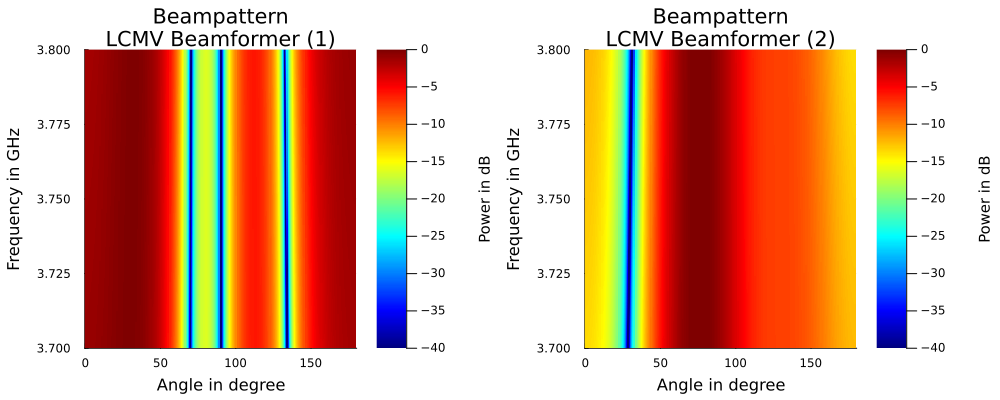

In [6]:
using CUDA
pa = IsotropicArray(cu([-6e-2, -2e-2, 2e-2, 6e-2]))

# Use the array below to better see the behaviour
#pa = IsotropicArray(cu(Vector(LinRange(-20e-2, 20e-2, 16))))

# Diagonal loading is applied by adding whitenoise to the correlation matrix
Snn = diffnoise(pa, 1e3, 3.75e9) + whitenoise(pa, 1e-2)

# Constraints C set for three directions
C = steer(pa, cu(deg2rad.([30 70 110])), 3.75e9)

# Two sets of gains for two sets of weights
G = cu([1 0; 0 1; 0.5 0.5])

weights = lcmv_weights(cu(Snn), C, G)
display(weights)

faxis = LinRange(3.7e9, 3.8e9, 1024)
ϕaxis = cu(collect(LinRange(0, 180, 256)))
A = cu.(steer.(Ref(pa), Ref(deg2rad.(ϕaxis)), faxis))
W1 = reduce(vcat, Ref(weights[:, 1]') .* A)
WdB1 = 20*log10.(abs.(W1))
W2 = reduce(vcat, Ref(weights[:, 2]') .* A)
WdB2 = 20*log10.(abs.(W2))

using Plots
import Measures
p1 = heatmap(Array(ϕaxis), faxis/1e9, Array(WdB1), cmap = :jet, clim=(-40, 0))
plot!(title="Beampattern\nLCMV Beamformer (1)", cbar_title="\nPower in dB", margin=5*Measures.mm)
xlabel!("Angle in degree")
ylabel!("Frequency in GHz")
p2 = heatmap(Array(ϕaxis), faxis/1e9, Array(WdB2), cmap = :jet, clim=(-40, 0))
plot!(title="Beampattern\nLCMV Beamformer (2)", cbar_title="\nPower in dB", margin=5*Measures.mm)
xlabel!("Angle in degree")
ylabel!("Frequency in GHz")

display(plot(p1, p2, layout=(1, 2), size=(1000, 400)))